# Starbucks Capstone Challenge

## Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [76]:
import pandas as pd
import numpy as np
import math
import json
import xgboost as xgb
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

## Introduction

The data exploration and feature engineering was implemented in the notebook "data_exploration_engineering.ipynb"

The objective of this notebook is to experiment with different classification models and determine which is the most suitable for the current data and problem

Let's start by loading the training data that was created in the notebook  "data_exploration_engineering.ipynb"

In [4]:
training_df = pd.read_csv('data/dataset.csv')
training_df.columns

Index(['reward', 'difficulty', 'duration', 'std_income', 'std_age', 'bogo',
       'discount', 'informational', 'F', 'M', 'O', 'type_of_membership',
       'completed'],
      dtype='object')

### Let's recall the correlation of features

In [8]:
correlation_matrix = training_df.corr()
correlation_matrix['completed'].sort_values(ascending=False)

completed             1.000000
duration              0.196006
discount              0.150572
difficulty            0.129000
reward                0.125238
type_of_membership    0.120718
std_income            0.088242
bogo                  0.080825
F                     0.062272
std_age               0.036803
O                     0.011196
M                    -0.064629
informational        -0.283437
Name: completed, dtype: float64

it can be seen that the features most correlated to a successful offer(completed=1.0) are (in descending order): duration,discount,difficulty,reward and type of membership ( which was derived from total_days_of_membership)

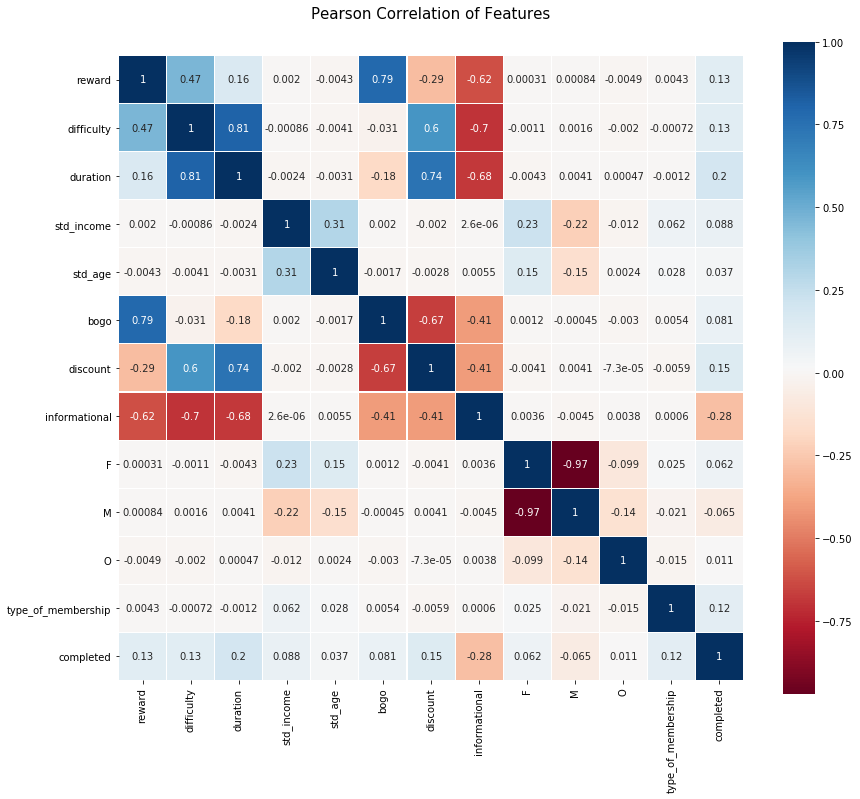

In [77]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(correlation_matrix,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

## Dealing with imbalanced classes




In [15]:
total_completed = len(training_df.loc[ (training_df['completed']==1.0)]) 
percentage_completed = (total_completed / len(training_df) ) * 100

print('Total offers completed {total}'.format(total=total_completed))
print('Percentage offers Completed {total}'.format(total=percentage_completed))

print('Total offers NO completed {total}'.format(total=len(training_df.loc[ (training_df['completed']==0.0)]) ))

Total offers completed 16173
Percentage offers Completed 24.319935038570847
Total offers NO completed 50328


It is clear that our model has a significant degree of imbalance between completed and uncompleted offers, with completed offers representing only approximately 25% of the total.

Class imbalance affects accuracy negatively, so something must be done so that model performance can still be evaluated using accuracy. This indicates that we should use a strategy to manage imbalanced classes, either by some method of increasing the minority class samples or decreasing the majority class samples or by using a classification model that is little affected by the class imbalance

### Using an up-sample minority class strategy

By using the Up-sampling strategy we are randomly duplicating observations from the minority class, in this case successful offers (completed=1.0)  in order to reinforce its relevance on the dataset.

To implement this strategy we will use the **resample** module of scikitlearn

In [31]:
from sklearn.utils import resample

df_majority = training_df[training_df.completed==0.0]
df_minority = training_df[training_df.completed==1.0]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,       # sample with replacement
                                 n_samples=50328,    # to match majority class
                                 random_state=123)   # reproducible results
 
# Combine majority class with upsampled minority class
training_df_upsampled = pd.concat([df_majority, df_minority_upsampled])
training_df_upsampled.completed.value_counts()

1.0    50328
0.0    50328
Name: completed, dtype: int64

In [32]:
training_df_upsampled.shape

(100656, 13)

## Create a training and test set

Before dividing the data set into training and testing, it is important to look for a method of division that can be more effective than a purely random division. In this case I consider that it would be good that the training and test data set has an equal data proportion based on the column **type_of_membership** (which is calculated depending on the age of the client in the platform) 

In [42]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1 , test_size=0.2, random_state= 42 )

for train_index, test_index in split.split(training_df_upsampled,training_df_upsampled['type_of_membership']):
    strat_train_set = training_df_upsampled.iloc[train_index]
    strat_test_set  = training_df_upsampled.iloc[test_index]
    
print(strat_train_set.shape)
print(strat_test_set.shape)

(80524, 13)
(20132, 13)


In [40]:
strat_train_set['type_of_membership'].value_counts()/len(strat_train_set)

1    0.515250
2    0.277321
0    0.207429
Name: type_of_membership, dtype: float64

In [41]:
strat_test_set['type_of_membership'].value_counts()/len(strat_test_set)

1    0.515249
2    0.277320
0    0.207431
Name: type_of_membership, dtype: float64

In [104]:
X_train = strat_train_set.drop(columns=['completed'])
y_train = strat_train_set['completed']
print(X_train.shape)
print(y_train.shape)
X_train.columns

(80524, 12)
(80524,)


Index(['reward', 'difficulty', 'duration', 'std_income', 'std_age', 'bogo',
       'discount', 'informational', 'F', 'M', 'O', 'type_of_membership'],
      dtype='object')

In [105]:
X_test = strat_test_set.drop(columns=['completed'])
y_test = strat_test_set['completed']
print(X_test.shape)
print(y_test.shape)
X_test.columns

(20132, 12)
(20132,)


Index(['reward', 'difficulty', 'duration', 'std_income', 'std_age', 'bogo',
       'discount', 'informational', 'F', 'M', 'O', 'type_of_membership'],
      dtype='object')

# Training

### RandomForestClassifier


In [106]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)

rf.fit(X_train, y_train)

# Predict on training set
pred_y_4 = rf.predict(X_train)

print( "RandomForestClassifier Accuracy:" + str( round( accuracy_score(pred_y_4, y_train)*100,2)) )
 
# How many classes are our model predicting?
print( np.unique( pred_y_4 ) )


RandomForestClassifier Accuracy:95.01
[0. 1.]


#### Using and evaluating AUROC as a metric

Intuitively, AUROC represents the likelihood of one classification model to distinguishing observations from two classes. In other words, if you randomly select one observation from each class, AUROC tell the probability that the model will be able to "rank" them correctly

In [107]:

prob_y_4 = rf.predict_proba(X_train)
prob_y_4 = [p[1] for p in prob_y_4]

print( "AUROC: " + str(round(roc_auc_score(y_train, prob_y_4)*100,2)) )

AUROC: 99.0


### LogisticRegression

In [108]:
logistic_regressor = LogisticRegression()

logistic_regressor.fit(X_train, y_train)

pred_y_0 = logistic_regressor.predict(X_train)

print( "LogisticRegression Accuracy:" + str(round(accuracy_score(pred_y_0, y_train)*100,2)) )

print( np.unique( pred_y_0 ) )

LogisticRegression Accuracy:67.94
[0. 1.]


#### AUROC

In [109]:

prob_y_4 = logistic_regressor.predict_proba(X_train)
prob_y_4 = [p[1] for p in prob_y_4]

print( "AUROC: " + str(round(roc_auc_score(y_train, prob_y_4)*100,2)) )

AUROC: 74.51


### XGBRegressor

In [110]:
xg_reg = xgb.XGBRegressor(objective ='binary:logistic')
xg_reg.fit(X_train,y_train)
print(f'Accuracy of Logistic regression classifier on training set: {round(xg_reg.score(X_train, y_train)*100,2)}%.')

[21:07:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of Logistic regression classifier on training set: 33.95%.


### KNeighborsClassifier

In [111]:
knc = KNeighborsClassifier()

knc.fit(X_train, y_train)

# Predict on training set
pred_y_k = knc.predict(X_train)

print( "KNeighborsClassifier Accuracy:" + str( round( accuracy_score(pred_y_k, y_train)*100,2)) )
 

KNeighborsClassifier Accuracy:83.22


In [112]:
prob_y_4 = knc.predict_proba(X_train)
prob_y_4 = [p[1] for p in prob_y_4]

print( "AUROC: " + str(round(roc_auc_score(y_train, prob_y_4)*100,2)) )

AUROC: 92.45


## Which algorithm should be chosen?

Metrics showed that the best performing algorithm was **RandomForestClassifier**, the cause can be found in that decision trees often perform well on classification models because their hierarchical structure allows them to learn signals from both classes. And if we use Tree ensembles  like Random Forests the result will be better because the result of a Random Forests almost always outperform singular decision trees.

# Evaluating the final model on the test set

In [113]:
final_predictions = rf.predict(X_test)

print( "Model Accuracy: " + str(round( accuracy_score(final_predictions, y_test)*100,2)) )

Model Accuracy: 84.38


In [116]:
prob_y_4 = rf.predict_proba(X_test)
prob_y_4 = [p[1] for p in prob_y_4]

print( "AUROC: " + str(round(roc_auc_score(y_test, prob_y_4)*100,2)) )

AUROC: 91.07


After validating the model with the training data, it can be seen that the model is generalizing in a reasonable way. An accuracy of 85%, while not the highest, can be a good start for more complex models.

An AUROC of 91.07 is also very good for this model

## Conclusion

Working on this capstone project was really useful to be able to put into practice the fundamental concepts of data science and face the challenges of creating a model that is useful to solve a real life problem.

The most challenging part for me, and the one that took the most time, was to create a data set that would allow me to model the objectives stated in the problem statement.

It was also exciting to discover that there was a class imbalance in my data set, i.e. the number of successful offers only represented 25% of the total. This made me investigate and look for alternatives since the accuracy of a classification model depends on a balance in the number of samples of each label.

After so much playing with the data, I could understand that different models can be created from it, for example with a little effort you could create a regression model to predict how much a customer could spend on average after receiving an offer, another option could also be a regression model with which to predict the response time to an offer. And I'm sure that by taking more time other options can be discovered. This is really a very enriching project.

#### Improvement options?

I think there are opportunities for improvement, if I had more time I would try with Ensembling/Stacking algorithms. Another option would be to look at combining features to have a more simplified model.